# Summary of File:
We will be using JupyterLab from Anaconda in order to conduct the image analysis. We will first use the cv2, os, and io packages in order to load in our image data from the designated file path. Once the data is loaded, matplotlib and pandas will be used to conduct the Exploratory Data Analysis. Numpy, random, and sklearn packages will then be used to balance the data set and split it into training and testing data sets. Using the tensorflow and keras packages, we will build the different CNN models using the training data set. Afterwards, we will use the sklearn package again to build the SVM model. Finally, in order to assess model performance, we will use matplotlib to create heat maps and sklearn to assess other model performance metrics. 

In [1]:
# Use the pip install command in order to download any packages that do 
# not exist in your version of python

# pip install tensorflow
# pip install keras
# pip install sklearn
# pip install cv2
# pip install io
# pip install os

# for some versions of jupyterlab, you may need to call the packages differently
# tensorflow.keras.___ OR tf.keras.____

# Import necessary libraries:

import tensorflow as tf
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications import ResNet50, VGG16, VGG19
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import cv2
import os
import io

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
# Load in the data
labels = ['glioma', 'meningioma', 'pituitary']
image_size = 200

data_images = []
data_labels = []

for label in labels:
    dataPath = os.path.join('/Users/ashik/Downloads/Classified Brain Tumor',label)
    for file in tqdm(os.listdir(dataPath)):
        image = cv2.imread(os.path.join(dataPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 200*200.
        data_images.append(image)
        data_labels.append(labels.index(label))

100%|██████████| 930/930 [00:01<00:00, 636.42it/s]


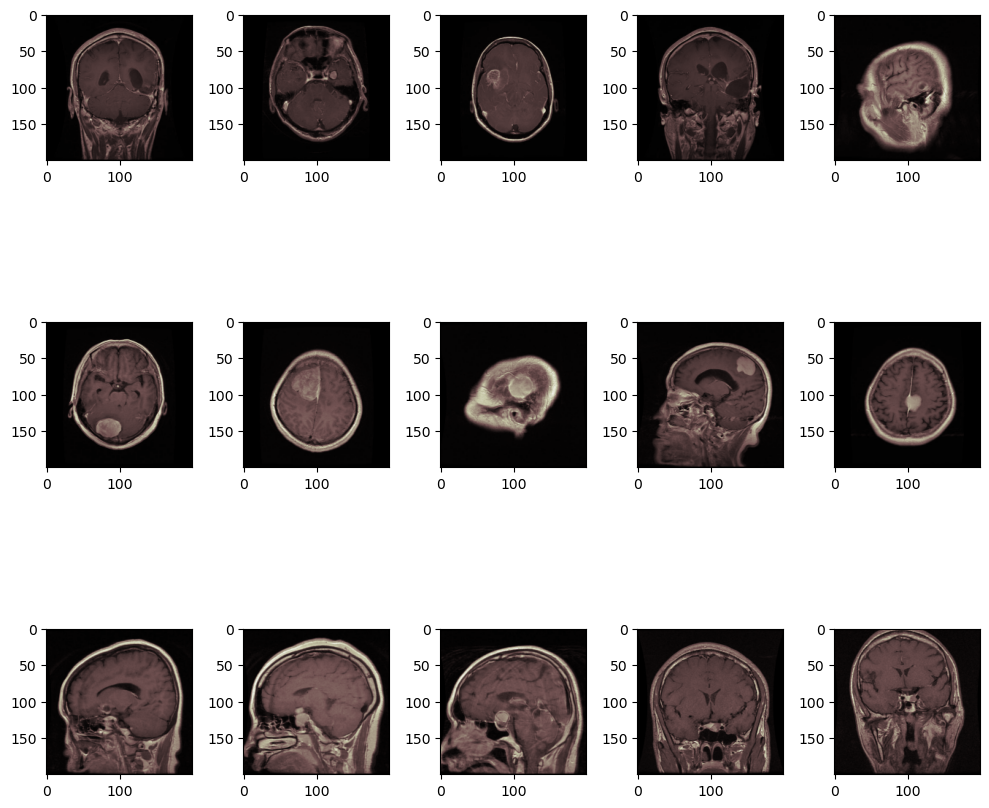

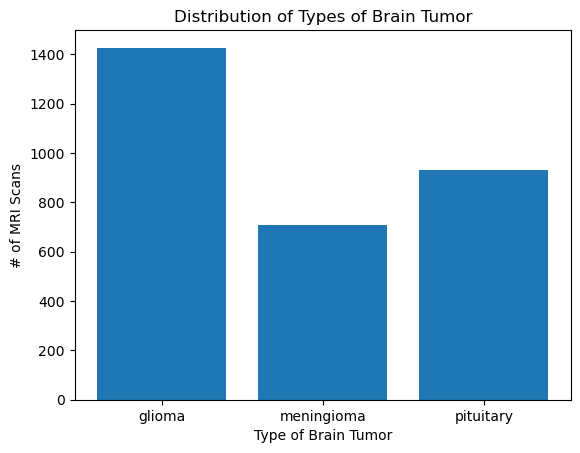

In [3]:
# Exploratory Data Analysis:
## This plot displays the 5 MRI scans for the three different tumor types
images = [data_images[i] for i in [1, 2, 3, 4, 5, 
                                   1427, 1428, 1429, 1430, 1431, 
                                   3050, 3051, 3052, 3053, 3054]]
fig, axes = plt.subplots(3, 5, figsize = (10, 10)) 
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()


## we are going to modify the labels so it is easier to read
## instead of using 0, 1, 2, we will recode them to glioma, meningioma, and pituitary
data_labels_df = pd.DataFrame(data_labels)
data_labels_df = data_labels_df.rename(columns={0: 'labels'})
data_labels_df['labels'] = data_labels_df['labels'].replace({0: 'glioma', 1: 'meningioma', 2:'pituitary'})
data_labels_groups = data_labels_df.groupby('labels')['labels'].count()
data_label_groups_df = pd.DataFrame(data_labels_groups)
data_label_groups_df.columns = ['count']
data_label_groups_df = data_label_groups_df.reset_index(drop = False)

## This plot displays the counts for each tumor type
plt.bar(data_label_groups_df['labels'], data_label_groups_df['count'])
plt.xlabel("Type of Brain Tumor")
plt.ylabel("# of MRI Scans")
plt.title("Distribution of Types of Brain Tumor")
plt.show()

## we see that the different kinds of tumors are not balanced really well
## glioma has twice as many tumors as meningioma

In [4]:
# Balancing the Data Set
## since there are fewer meningioma tumors, we will sample those number of 
## observations from the glioma and pituitary tumors
SEED = 625
np.random.seed(SEED)
random.seed(SEED)

data_labels = data_labels_df['labels']

## converting lists to numpy arrays
data_images = np.array(data_images)
data_labels = np.array(data_labels)

## splitting the arrays into the three different tumor groups
glioma_index = np.where(data_labels == 'glioma')[0]
meningioma_index = np.where(data_labels == 'meningioma')[0]
pituitary_index = np.where(data_labels == 'pituitary')[0]

## getting the count of the # meningioma MRI scans
min_count = len(meningioma_index)

## sampling the same count in the other two tumors
sampled_glioma_index = np.random.choice(glioma_index, size=min_count, replace=False)
sampled_pituitary_index = np.random.choice(pituitary_index, size=min_count, replace=False)

## combining all of the indices into one vector
balanced_indices = np.concatenate([sampled_glioma_index, meningioma_index, sampled_pituitary_index])

## shuffling all of the indices so it is randomized
np.random.shuffle(balanced_indices)

## using the balanced indices to subset the images and the labels
data_images_final = data_images[balanced_indices]
data_labels_final = data_labels[balanced_indices]


In [5]:
# Splitting the Data Set into Training, Validation, and Testing Data

## this will split it into a training data set and a temporary data set
X_train, X_test, y_train, y_test = train_test_split(
    data_images_final, data_labels_final, test_size=0.2, stratify=data_labels_final, random_state=SEED
)
# in the end, we should have a 80:20 split (80 ~ training, 20 ~ testing)

In [6]:
# Building the CNN Models
## duplicate the training data set and augment the data
X_train_cnn = X_train.copy()
y_train_cnn = y_train.copy()
x_test_cnn = X_test.copy()
y_test_cnn = y_test.copy()

datagen1 = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,                        
    width_shift_range=0.10,
    height_shift_range=0.10,
    horizontal_flip=True)

## after creating and configuring ImageDataGenerator, fit it to the training data.
datagen1.fit(X_train_cnn)

## now we can build the models
## (we will look at 3 pre-trained model weights: ResNet 50, VGG-16, and VGG-19)

### Building the CNN model using ResNet50 model weights
net1 = ResNet50(
    weights='imagenet',
     include_top=False,
     input_shape=(image_size,image_size,3))

model1 = net1.output
model1 = GlobalAveragePooling2D()(model1)
model1 = Dropout(0.4)(model1)
model1 = Dense(3, activation="softmax")(model1)
model1_cnn = Model(inputs= net1.input, outputs= model1)

#compile our model.
adam = Adam(learning_rate=0.0001)
model1_cnn.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model1_cnn.summary()

### Building the CNN model using VGG-16 model weights
net2 = VGG16(
    weights='imagenet',
     include_top=False,
     input_shape=(image_size,image_size,3))

model2 = net2.output
model2 = GlobalAveragePooling2D()(model2)
model2 = Dropout(0.4)(model2)
model2 = Dense(3, activation="softmax")(model2)
model2_cnn = Model(inputs= net2.input, outputs= model2)

#compile our model.
adam = Adam(learning_rate=0.0001)
model2_cnn.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model2_cnn.summary()

### Building the CNN model using VGG-19 model weights
net3 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size,image_size,3))
 
model3 = net3.output
model3 = GlobalAveragePooling2D()(model3)
model3 = Dropout(0.4)(model3)
model3 = Dense(3, activation="softmax")(model3)
model3_cnn = Model(inputs= net3.input, outputs= model3)

#compile our model.
adam = Adam(learning_rate=0.0001)
model3_cnn.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model3_cnn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 14,716,227 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,025,923 (76.39 MB)

 Trainable params: 20,025,923 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Building SVM Model
## flatten the data so we can build the SVM model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

## scaling the features (need to do this so the data meets the necessary assumptions to build the SVM model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

## conducting PCA analysis in order reduce the dimensions of the image data
## if this step is not done, building a SVM model without using dimension reduction is computationally expensive
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


## define parameter grid (these will be the different parameters we will test when we use cross validation)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

## initializing the model and determining the best parameters
## during this step, the GridSearchCV function will go through the different combinations of 
## parameters and determine what the best model is
svc = svm.SVC(probability=True)
model_svm_reduced = GridSearchCV(svc, param_grid, cv=3, verbose=2, n_jobs=-1)
model_svm_reduced.fit(X_train_pca, y_train)

# Best parameters
print("Best parameters:", model_svm_reduced.best_params_)

# building the final svm model with the best parameters
best_params = model_svm_reduced.best_params_

final_svm_reduced = svm.SVC(
    C=best_params['C'],
    gamma=best_params['gamma'],
    kernel=best_params['kernel'],
    probability=True
)

final_svm_reduced.fit(X_train_pca, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time=   0.8s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.8s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.8s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.0s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   2.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   2.1s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.8s
[CV] END ......................C=0.1, gamma=0.1,

SVC(C=0.1, gamma=0.0001, kernel='poly', probability=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


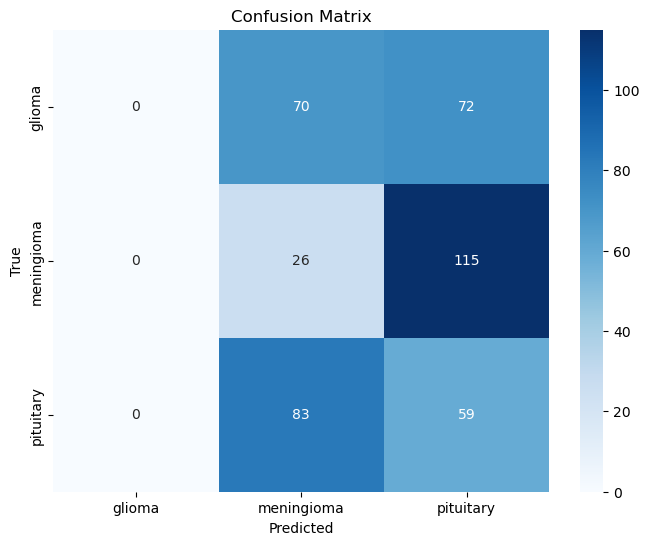

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       142
  meningioma       0.15      0.18      0.16       141
   pituitary       0.24      0.42      0.30       142

    accuracy                           0.20       425
   macro avg       0.13      0.20      0.16       425
weighted avg       0.13      0.20      0.16       425

Accuracy: 0.2000


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Testing Model Performance
## scale the test data
X_test = X_test / 255.0  # Rescale if necessary

## making predictions with your ResNet CNN model
y_pred = model1_cnn.predict(X_test)

# converting predictions to numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
y_pred_classes = np.argmax(y_pred, axis=1)

# converting the true values into numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
y_true = np.array([label_mapping[label] for label in y_test_cnn])

# making the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# graphing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma', 'meningioma', 'pituitary'], yticklabels=['glioma', 'meningioma', 'pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# getting other classification metrics
report = classification_report(y_true, y_pred_classes, target_names=['glioma', 'meningioma', 'pituitary'])
print(report)

# calculating the accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step


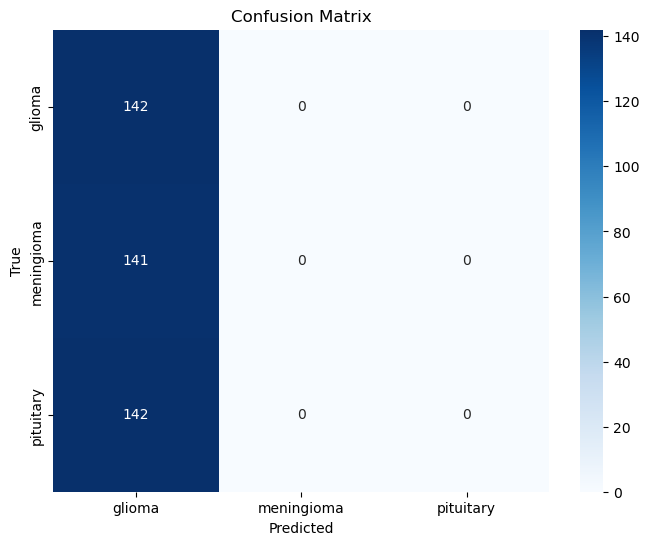

              precision    recall  f1-score   support

      glioma       0.33      1.00      0.50       142
  meningioma       0.00      0.00      0.00       141
   pituitary       0.00      0.00      0.00       142

    accuracy                           0.33       425
   macro avg       0.11      0.33      0.17       425
weighted avg       0.11      0.33      0.17       425

Accuracy: 0.3341


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Testing Model Performance (cont.)
## making predictions with your VGG16 CNN model
y_pred = model2_cnn.predict(X_test)

# converting predictions to class numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
y_pred_classes = np.argmax(y_pred, axis=1)

# converting the true values into numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
y_true = np.array([label_mapping[label] for label in y_test_cnn])

# making the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# graphing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma', 'meningioma', 'pituitary'], yticklabels=['glioma', 'meningioma', 'pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# getting other classification metrics
report = classification_report(y_true, y_pred_classes, target_names=['glioma', 'meningioma', 'pituitary'])
print(report)

# calculating the accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 111s 8s/step


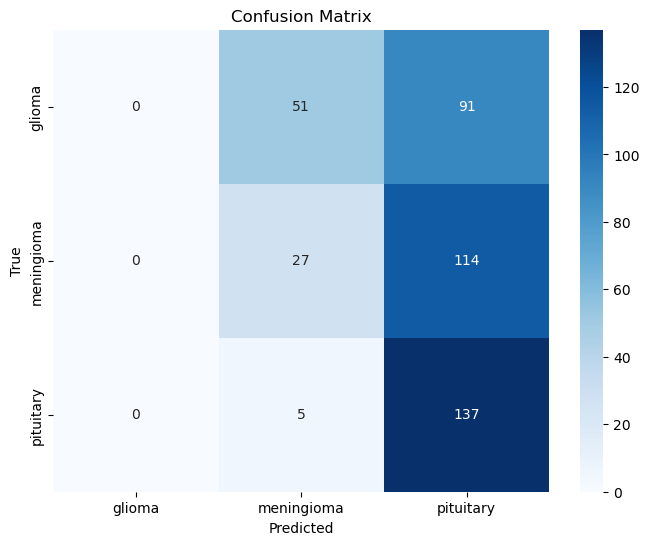

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       142
  meningioma       0.33      0.19      0.24       141
   pituitary       0.40      0.96      0.57       142

    accuracy                           0.39       425
   macro avg       0.24      0.39      0.27       425
weighted avg       0.24      0.39      0.27       425

Accuracy: 0.3859


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Testing Model Performance (cont.)
## making predictions with your VGG19 CNN model
y_pred = model3_cnn.predict(X_test)

# converting predictions to class numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
y_pred_classes = np.argmax(y_pred, axis=1)

# converting the true values into numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
y_true = np.array([label_mapping[label] for label in y_test_cnn])

# making the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# graphing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma', 'meningioma', 'pituitary'], yticklabels=['glioma', 'meningioma', 'pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# getting other classification metrics
report = classification_report(y_true, y_pred_classes, target_names=['glioma', 'meningioma', 'pituitary'])
print(report)

# calculating the accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

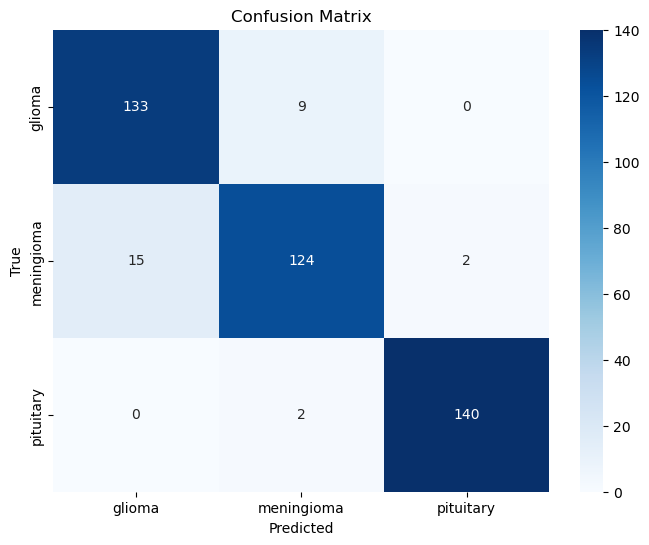

              precision    recall  f1-score   support

      glioma       0.90      0.94      0.92       142
  meningioma       0.92      0.88      0.90       141
   pituitary       0.99      0.99      0.99       142

    accuracy                           0.93       425
   macro avg       0.93      0.93      0.93       425
weighted avg       0.93      0.93      0.93       425

Accuracy: 0.9341


In [18]:
# Testing Model Performance (cont.)
## making predictions with your SVM model
y_pred = final_svm_reduced.predict(X_test_pca)

# converting predictions to class numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
y_pred = np.array([label_mapping[label] for label in y_pred])

# converting the true values into numbers (ie: going from glioma, meningioma, pituitary to 0, 1, 2)
label_mapping = {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
y_true = np.array([label_mapping[label] for label in y_test])

# making the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# graphing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['glioma', 'meningioma', 'pituitary'], yticklabels=['glioma', 'meningioma', 'pituitary'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# getting other classification metrics
report = classification_report(y_true, y_pred, target_names=['glioma', 'meningioma', 'pituitary'])
print(report)

# calculating the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

## overall, the CNN models perform horribly. they tend to overpredict certain types of tumors and underpredict others dependeing
## upon which model weights are used. this makes sense because the CNN models need a lot of image data (especially when dealing with
## MRI scans), and since we did not look into things like early stopping, learning rates, and callbacks, the model performs even
## worse. 

## the SVM model does a really good job at predicting the type of tumors